In [1]:
import tensorflow as tf
import numpy as np
import time
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from IcGanLayer import gan_loss, classify_loss, autoencoder_loss, generator
from dataset_and_utils import prepare_datasets, show_image, show_gen, list_devices, prepare_new_datasets, save_image

In [2]:
n_classes = 309
batch_size = 32

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
config.log_device_placement=True
config.allow_soft_placement=True

In [10]:
train_dataset, val_dataset, test_dataset = prepare_new_datasets(batch_size)

Duration is 41.916738986968994
Duration is 7.906036615371704
Duration is 7.751373767852783


In [5]:
tf.reset_default_graph()
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 64, 64,  3], name='x')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
    
    loss_autoencoder = autoencoder_loss(x, y, n_classes)
    loss_pred, loss_gen, gen, pred_fake, pred_real= gan_loss(x, y, n_classes)
    loss_cls, Ey = classify_loss(x, y, n_classes)
    
    evaluate = tf.equal(tf.round(Ey), y)
    accuracy = tf.reduce_mean(tf.cast(evaluate,dtype=tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        autoencoder_optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss_autoencoder)
        pred_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(loss_pred)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(loss_gen)
        cls_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(loss_cls)
    

Epoch 1 Iter 500 0m:20s -- utoencoder loss: 0.087872
Epoch 1 Iter 1000 0m:44s -- utoencoder loss: 0.049203
Epoch 1 Iter 1500 1m:8s -- utoencoder loss: 0.039448
Epoch 1 Iter 2000 1m:41s -- utoencoder loss: 0.036978
Epoch 1 Iter 2500 2m:6s -- utoencoder loss: 0.035098
Epoch 1 Iter 3000 2m:49s -- utoencoder loss: 0.033145
Epoch 1 Iter 3500 3m:13s -- utoencoder loss: 0.029216
Epoch 1 Iter 4000 3m:52s -- utoencoder loss: 0.029275


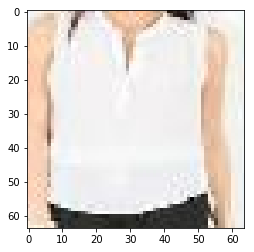

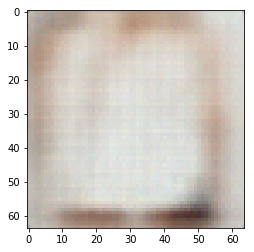

Epoch 2 Iter 500 4m:49s -- utoencoder loss: 0.028245
Epoch 2 Iter 1000 5m:13s -- utoencoder loss: 0.030103
Epoch 2 Iter 1500 5m:50s -- utoencoder loss: 0.027054
Epoch 2 Iter 2000 6m:15s -- utoencoder loss: 0.026745
Epoch 2 Iter 2500 6m:53s -- utoencoder loss: 0.026293
Epoch 2 Iter 3000 7m:18s -- utoencoder loss: 0.025380
Epoch 2 Iter 3500 7m:57s -- utoencoder loss: 0.023285
Epoch 2 Iter 4000 8m:21s -- utoencoder loss: 0.024401


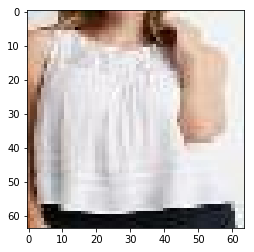

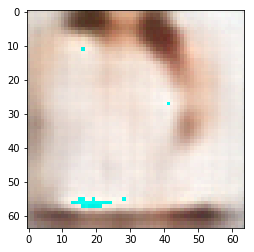

Epoch 3 Iter 500 9m:18s -- utoencoder loss: 0.023568
Epoch 3 Iter 1000 9m:56s -- utoencoder loss: 0.025394
Epoch 3 Iter 1500 10m:21s -- utoencoder loss: 0.023302
Epoch 3 Iter 2000 10m:59s -- utoencoder loss: 0.022721
Epoch 3 Iter 2500 11m:24s -- utoencoder loss: 0.022659
Epoch 3 Iter 3000 12m:2s -- utoencoder loss: 0.025340
Epoch 3 Iter 3500 12m:28s -- utoencoder loss: 0.021862
Epoch 3 Iter 4000 13m:6s -- utoencoder loss: 0.022690


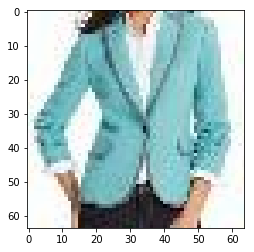

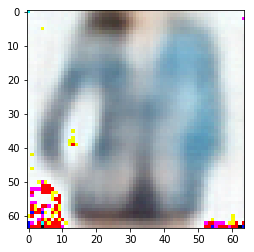

Epoch 4 Iter 500 14m:3s -- utoencoder loss: 0.021418
Epoch 4 Iter 1000 14m:42s -- utoencoder loss: 0.023872
Epoch 4 Iter 1500 15m:7s -- utoencoder loss: 0.021458
Epoch 4 Iter 2000 15m:46s -- utoencoder loss: 0.021022
Epoch 4 Iter 2500 16m:11s -- utoencoder loss: 0.020925
Epoch 4 Iter 3000 16m:51s -- utoencoder loss: 0.020401
Epoch 4 Iter 3500 17m:16s -- utoencoder loss: 0.019707
Epoch 4 Iter 4000 17m:55s -- utoencoder loss: 0.021018


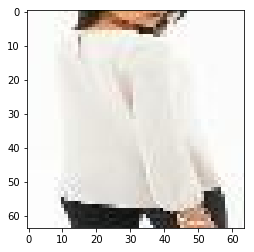

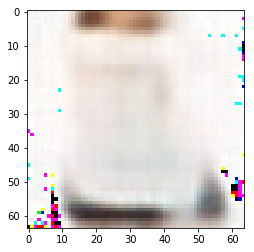

Epoch 5 Iter 500 18m:55s -- utoencoder loss: 0.020040
Epoch 5 Iter 1000 19m:20s -- utoencoder loss: 0.022183
Epoch 5 Iter 1500 19m:57s -- utoencoder loss: 0.020151
Epoch 5 Iter 2000 20m:21s -- utoencoder loss: 0.019770
Epoch 5 Iter 2500 20m:59s -- utoencoder loss: 0.019692
Epoch 5 Iter 3000 21m:23s -- utoencoder loss: 0.019122
Epoch 5 Iter 3500 22m:0s -- utoencoder loss: 0.018612
Epoch 5 Iter 4000 22m:24s -- utoencoder loss: 0.020050


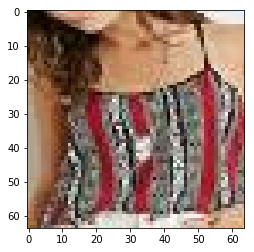

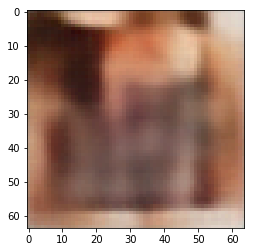

In [12]:
# Train AutoEncoder
n_epoch = 5
test_every = 1
iter_print_every = 500

train_iterator = train_dataset.make_one_shot_iterator()
next_batch_data = train_iterator.get_next()

val_iterator = val_dataset.make_one_shot_iterator()
next_batch_val = val_iterator.get_next()

sess = tf.InteractiveSession(config=config)
init = tf.global_variables_initializer()
sess.run(init)

since = time.time()
epoch = 0
autoencoder_cost = 0.

while(epoch < n_epoch):
    iter_cnt = 0
    total_autoencoder_cost = 0.
    
    while True:
        iter_cnt += 1
        try:
            imgs, labs = sess.run(next_batch_data)
            _, autoencoder_cost = sess.run([autoencoder_optimizer, loss_autoencoder], feed_dict={x:imgs, y:labs})
                                   
            total_autoencoder_cost += autoencoder_cost
            
            if (iter_cnt + 1) % iter_print_every == 0:
                uptime = time.time() - since
                print('Epoch %d Iter %d %dm:%ds -- autoencoder loss: %f' % (epoch+1,iter_cnt+1,
                                                                   uptime//60, uptime%60,
                                                                   total_autoencoder_cost/iter_print_every))
                total_autoencoder_cost = 0.
    
       
        except tf.errors.OutOfRangeError:
            train_iterator = train_dataset.make_one_shot_iterator()
            next_batch_data = train_iterator.get_next()
            break
            
    if (epoch+1) % test_every == 0:
        try:
            imgs, labs = sess.run(next_batch_val)
        except:
            val_iterator = val_dataset.make_one_shot_iterator()
            next_batch_val = val_iterator.get_next()
            imgs, labs = sess.run(next_batch_val)

        val_image = sess.run([gen], feed_dict={x:imgs, y:labs})

        show_image(imgs[0])
        val_image = np.array(val_image)
        show_image(np.squeeze(val_image)[0])
    
    epoch += 1

In [14]:
saver.save(sess, 'model/autoencoder_5_epochs_model.ckpt')

'model/autoencoder_5_epochs_model.ckpt'

In [ ]:
show_gen(next_batch, gen):
    imgs, labs = sess.run(next_batch_val)
    gen_image = sess.run([gen], feed_dict={x:imgs, y:labs})

    show_image(imgs[0])
    gen_image = np.array(gen_image)
    show_image(np.squeeze(gen_image)[0])
    
show_gen(next_batch_val, gen)

Epoch 1 Iter 50 0m:6s -- \discriminator loss: 3169311.280375, generator loss: 8666160.793125
Epoch 1 Iter 100 0m:12s -- \discriminator loss: 42032170.332500, generator loss: 27802164.570000
Epoch 1 Iter 150 0m:17s -- \discriminator loss: 66782877.952500, generator loss: 69866500.240000
Epoch 1 Iter 200 0m:23s -- \discriminator loss: 73319969.370000, generator loss: 88457959.760000
Epoch 1 Iter 250 0m:28s -- \discriminator loss: 78441758.510000, generator loss: 84651572.800000
Epoch 1 Iter 300 0m:34s -- \discriminator loss: 51984558.347734, generator loss: 113468298.120000
Epoch 1 Iter 350 0m:39s -- \discriminator loss: 104056739.120000, generator loss: 66519472.120000
Epoch 1 Iter 400 0m:44s -- \discriminator loss: 62481839.004297, generator loss: 107929786.080000
Epoch 1 Iter 450 0m:50s -- \discriminator loss: 102710853.120000, generator loss: 73234527.200000
Epoch 1 Iter 500 0m:55s -- \discriminator loss: 40944853.920000, generator loss: 134778092.560000
Epoch 1 Iter 550 1m:1s -- \di

Epoch 1 Iter 4250 7m:49s -- \discriminator loss: 165164391.360000, generator loss: 69625826.800000
Epoch 1 Iter 4300 7m:57s -- \discriminator loss: 152603776.320000, generator loss: 82396836.960000


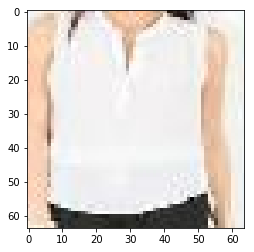

ValueError: Floating point image RGB values must be in the 0..1 range.

Epoch 2 Iter 50 8m:9s -- \discriminator loss: 20125983.980000, generator loss: 96314227.120000
Epoch 2 Iter 100 8m:15s -- \discriminator loss: 5132380.093750, generator loss: 113200077.360000
Epoch 2 Iter 150 8m:20s -- \discriminator loss: 111107403.280000, generator loss: 7972560.230000
Epoch 2 Iter 200 8m:25s -- \discriminator loss: 101515672.160000, generator loss: 19714542.680000
Epoch 2 Iter 250 8m:30s -- \discriminator loss: 89916694.560000, generator loss: 32193385.400000
Epoch 2 Iter 300 8m:36s -- \discriminator loss: 78713729.280000, generator loss: 44200932.080000
Epoch 2 Iter 350 8m:41s -- \discriminator loss: 67913640.160000, generator loss: 55734874.720000
Epoch 2 Iter 400 8m:46s -- \discriminator loss: 57519365.360000, generator loss: 66796873.040000
Epoch 2 Iter 450 8m:52s -- \discriminator loss: 47530226.000000, generator loss: 77391936.160000
Epoch 2 Iter 500 8m:57s -- \discriminator loss: 37942658.160000, generator loss: 87527989.920000
Epoch 2 Iter 550 9m:2s -- \disc

In [ ]:
n_epoch = 100
halve_lr_every = 20
test_every = 1
save_model_every = 10
iter_print_every = 50
lr = 2 * 10-4

# train_iterator = train_dataset.make_initializable_iterator()
# val_iterator = val_dataset.make_initializable_iterator()
train_iterator = train_dataset.make_one_shot_iterator()
next_batch_data = train_iterator.get_next()

val_iterator = val_dataset.make_one_shot_iterator()
next_batch_val = val_iterator.get_next()


#with tf.Session(config=config) as sess:
sess = tf.InteractiveSession(config=config)
init = tf.global_variables_initializer()
sess.run(init)
# sess.run(train_iterator.initializer, feed_dict={max_value: 32})
# sess.run(val_iterator.initializer)
since = time.time()
epoch = 0
pred_cost = 0.
gen_cost = 0.

while(epoch < n_epoch):
    iter_cnt = 0
    total_pred_cost = 0.
    total_gen_cost = 0.
    
    while True:
        iter_cnt += 1
        try:
            imgs, labs = sess.run(next_batch_data)
    
            _, pred_cost = sess.run([pred_optimizer, loss_pred], feed_dict={x:imgs, y:labs, learning_rate:lr})
            _, gen_cost = sess.run([gen_optimizer, loss_gen], feed_dict={x:imgs, y:labs, learning_rate:lr})
            
            #print('pred_fake', pred_fake.eval(feed_dict={x:imgs, y:labs, learning_rate:lr}))
            #print('pred_real', pred_real.eval(feed_dict={x:imgs, y:labs, learning_rate:lr}))
            #gen_img = gen.eval(feed_dict={x:imgs, y:labs, learning_rate:lr})
            #print(gen_img, gen.shape)
                                   
            total_pred_cost += pred_cost
            total_gen_cost += gen_cost
            
            if (iter_cnt + 1) % iter_print_every == 0:
                uptime = time.time() - since
                print('Epoch %d Iter %d %dm:%ds -- \discriminator loss: %f, generator loss: %f' % (epoch+1,iter_cnt+1,
                                                                   uptime//60, uptime%60,
                                                                   total_pred_cost/iter_print_every,
                                                                   total_gen_cost/iter_print_every))
                total_pred_cost = 0.
                total_gen_cost = 0.
    
       
        except tf.errors.OutOfRangeError:
            train_iterator = train_dataset.make_one_shot_iterator()
            next_batch_data = train_iterator.get_next()
            break
            
    if (epoch+1) % test_every == 0:
        try:
            imgs, labs = sess.run(next_batch_val)
        except:
            val_iterator = val_dataset.make_one_shot_iterator()
            next_batch_val = val_iterator.get_next()
            imgs, labs = sess.run(next_batch_val)

        val_image = sess.run([gen], feed_dict={x:imgs, y:labs, learning_rate:lr})

        show_image(imgs[0])
        val_image = np.array(val_image)
        show_image(np.squeeze(val_image)[0])

    if (epoch+1) % save_model_every == 0:
        saver.save(sess, 'model/IcGan_'+str(epoch+1)+'_epochs')

    if (epoch+1) % halve_lr_every:
        lr /= 2
    
    epoch += 1

saver.save(sess, 'model/IcGan_final_model')

In [8]:
sess.close()

In [6]:

saver = tf.train.import_meta_graph('./model/IcGan_20_epochs.meta')
saver.restore(sess,tf.train.latest_checkpoint('./model'))

INFO:tensorflow:Restoring parameters from ./model/IcGan_20_epochs


[  82 : info                           ] Restoring parameters from ./model/IcGan_20_epochs


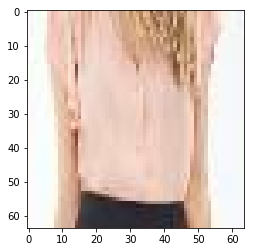

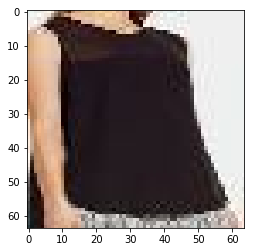

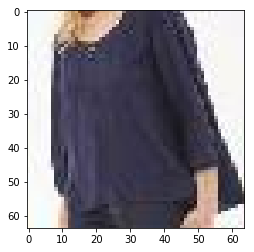

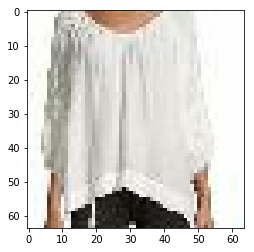

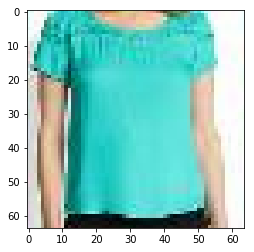

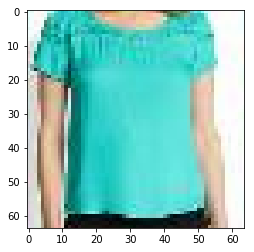

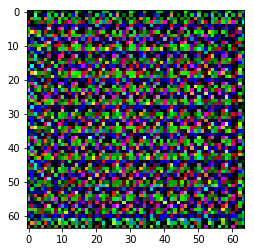

In [12]:
imgs, labs = sess.run(next_batch_data)
show_image(imgs[])
val_image = sess.run([gen], feed_dict={x:imgs, y:labs, learning_rate:lr})

show_image(imgs[1])
val_image = np.array(val_image)
show_image(np.squeeze(val_image)[1])

In [ ]:
imgs[0]

In [15]:
test_image = np.array(test_image)
print(test_image)
show_image(np.squeeze(test_image)[0])

[[[[[ 0.01731281 -0.00049786 -0.00051697]
    [ 0.0268098  -0.02541385  0.01045074]
    [ 0.02335242 -0.00472535  0.000988  ]
    ..., 
    [ 0.02309056 -0.0233418   0.00030125]
    [ 0.01858981 -0.00071221 -0.00074584]
    [ 0.00630514 -0.00156878 -0.00217882]]

   [[ 0.01544815 -0.00251214  0.00103776]
    [ 0.02088345  0.0127382  -0.02702123]
    [ 0.02707589  0.04212866 -0.0209272 ]
    ..., 
    [ 0.01083681  0.00754928 -0.02845698]
    [ 0.02097915  0.04105031 -0.02113053]
    [ 0.02737332  0.0151865   0.0047413 ]]

   [[ 0.02455161 -0.00475989 -0.01290123]
    [ 0.04648749 -0.00521686 -0.00242949]
    [ 0.02918772  0.04352136  0.00890721]
    ..., 
    [ 0.04670377  0.00393848 -0.01058939]
    [ 0.01506993  0.04881216  0.00720783]
    [ 0.00852257 -0.00583907  0.00246301]]

   ..., 
   [[ 0.02219488  0.00472032  0.00305387]
    [ 0.01431249  0.00610014 -0.02272281]
    [ 0.03196518  0.03460883 -0.02070677]
    ..., 
    [ 0.01392783  0.00794118 -0.02172735]
    [ 0.02281539  0.0

ValueError: Floating point image RGB values must be in the 0..1 range.

In [ ]:
with tf.Session(config=config) as sess:
    for epoch in range(n_iters):
        cls_cost = sess,run([cls_optimizer], feed_dict={x:dataset.nextbatch(), y:label.nextbatch()})
        print('classifer loss: %f, accuracy: %f' % (cls_cost, accuracy.eval()))
    saver.save(sess, 'save/to/path')
        